In [42]:
import numpy as np
from collections import OrderedDict

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#def softmax(x):
#        c = np.max(x)
#        exp_x = np.exp(x - c)
#        sum_exp_x = np.sum(exp_x)
#        y = exp_x / sum_exp_x
#        
#        return y
 
def softmax(x):
    if x.ndim == 2:
        c = np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x - c)
        sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
        return exp_x / sum_exp_x
    else:
        c = np.max(x)
        exp_x = np.exp(x - c)
        return exp_x / np.sum(exp_x)
       
def CEE(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

def gradient(f, x):
    h = 0.0001

    shape = x.shape
    x_flatten = x.reshape(-1)
    size = len(x_flatten)

    grad = np.zeros_like(x_flatten)

    for i in range(size):
        x_val = x_flatten[i]

        x_flatten[i] = x_val + h
        fxh1 = f(x_flatten.reshape(shape))

        x_flatten[i] = x_val - h
        fxh2 = f(x_flatten.reshape(shape))

        grad[i] = (fxh1 - fxh2) / (2*h)

        x_flatten[i] = x_val
        
    return grad.reshape(shape)

class ReLU:
    def __init__(self):
        self.x = None
        
    def forward(self, x):
        self.x = x
        return (x > 0)*x
    
    def backward(self, dz):
        return dz*(self.x > 0).astype(int)
    
class Sigmoid:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x):
        self.x = x
        self.y = 1 / (1 + np.exp(-self.x))
        return self.y
    
    def backward(self, dz):
        return dz * self.y *(1 - self.y)
    
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.X = None 
        
    def forward(self, X):
        self.X = X        
        return np.dot(X, self.W) + self.b
    
    def backward(self, dz):
        grads = {}
        grads["W"] = np.dot(self.X.T, dz)
        grads["X"] = np.dot(dz, self.W.T)
        grads["b"] = np.sum(dz, axis=0)
        
        return grads

class Softmax_with_Loss:
    def __init__(self):
        self.y = None
        self.t = None
        
    def forward(self, X, t):
        self.y = softmax(X)
        self.t = t
        loss = CEE(self.y, self.t)
        
        return loss
    
    def backward(self):
        batch_size = self.t.shape[0]
        return (self.y - self.t) / batch_size
    
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        self.params = {}
        # layer 1
        self.params["W1"] = 0.01 * np.random.randn(input_size,hidden_size)
        self.params["B1"] = np.zeros(hidden_size)
        #layer 2
        self.params["W2"] = 0.01 * np.random.randn(hidden_size,output_size)
        self.params["B2"] = np.zeros(output_size)
        
        self.layer = OrderedDict()
        self.layer["Affine1"] = Affine(self.params["W1"], self.params["B1"])
        self.layer["ReLU1"] = ReLU()
        self.layer["Affine2"] = Affine(self.params["W2"], self.params["B2"])
        
        self.last_layer = Softmax_with_Loss()
        
    def predict(self, X):
        h = self.layer["Affine1"].forward(X)
        h = self.layer["ReLU1"].forward(h)
        y = self.layer["Affine2"].forward(h)
        
        return y
        
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.last_layer.forward(y, t)
        return loss
    
    def accuracy(self, x, t):
        Y = self.predict(x)
        predict_label = np.argmax(Y, axis=1)
        target_label = np.argmax(t, axis=1)
        return np.sum(predict_label == target_label) / len(predict_label)
    
    def numerical_gradient(self, x, t):
        grads = {}

        for key in self.params:
            original_param = self.params[key]

            def loss_func(param):
                self.params[key][...] = param
                y = self.predict(x)
                return self.last_layer.forward(y, t)

            h = 1e-4
            shape = original_param.shape
            param_flat = original_param.reshape(-1)
            grad = np.zeros_like(param_flat)

            for i in range(len(param_flat)):
                tmp_val = param_flat[i]

                param_flat[i] = tmp_val + h
                fxh1 = loss_func(param_flat.reshape(shape))

                param_flat[i] = tmp_val - h
                fxh2 = loss_func(param_flat.reshape(shape))

                grad[i] = (fxh1 - fxh2) / (2 * h)

                param_flat[i] = tmp_val

            grads[key] = grad.reshape(shape)
            #self.params[key] = original_param
        return grads
    
    def gradient(self, x, t):
        loss = self.loss(x, t)
        grads = {}
        
        dout = self.last_layer.backward()
        temp_grads = self.layer["Affine2"].backward(dout)
        grads["W2"] = temp_grads["W"]
        grads["B2"] = temp_grads["b"]
        dout = temp_grads["X"]
        
        dout = self.layer["ReLU1"].backward(dout)
        
        temp_grads = self.layer["Affine1"].backward(dout)
        grads["W1"] = temp_grads["W"]
        grads["B1"] = temp_grads["b"]
        
        return grads

In [43]:
class SGD:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr*grads[key]

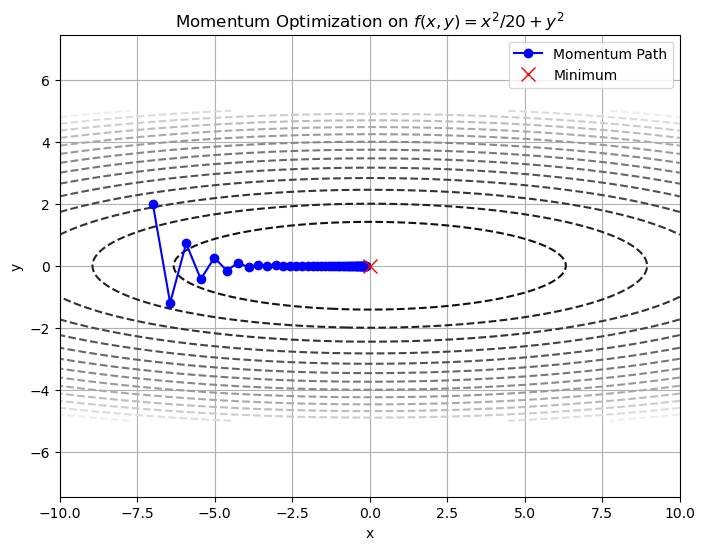

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# 함수 정의 및 수치 미분
def function_2(params):
    x, y = params['x']
    return (x ** 2) / 20 + y ** 2

def numerical_gradient(f, params):
    h = 1e-4
    grad = {}
    x = params['x']
    grad['x'] = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(params)

        x[idx] = tmp_val - h
        fxh2 = f(params)

        grad['x'][idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

# 초기화
init_pos = np.array([-7.0, 2.0])
params = {'x': init_pos.copy()}
optimizer = SGD(lr=0.8)

x_history = []

# 최적화 루프
for _ in range(50):
    x_history.append(params['x'].copy())
    grads = numerical_gradient(function_2, params)
    optimizer.update(params, grads)

x_history = np.array(x_history)

# 등고선 그리기
x = np.linspace(-10, 10, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = (X ** 2) / 20 + Y ** 2

plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=15, cmap='gray', linestyles='dashed')
plt.plot(x_history[:, 0], x_history[:, 1], 'o-', color='blue', label='Momentum Path')
plt.plot(0, 0, 'rx', markersize=10, label='Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Momentum Optimization on $f(x, y) = x^2/20 + y^2$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [45]:
class Momentum:
    def __init__(self, lr, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v == None:
            self.v = {}
            for key, param in params.items():
                self.v[key] = np.zeros_like(param)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

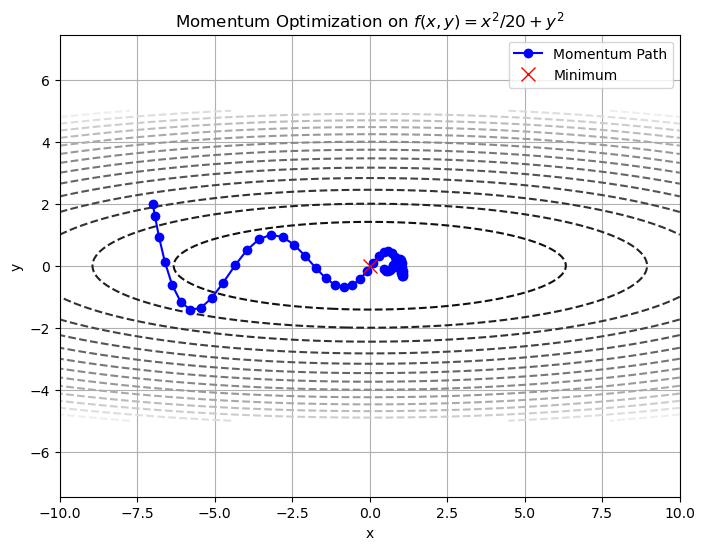

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# 함수 정의 및 수치 미분
def function_2(params):
    x, y = params['x']
    return (x ** 2) / 20 + y ** 2

def numerical_gradient(f, params):
    h = 1e-4
    grad = {}
    x = params['x']
    grad['x'] = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(params)

        x[idx] = tmp_val - h
        fxh2 = f(params)

        grad['x'][idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

# 초기화
init_pos = np.array([-7.0, 2.0])
params = {'x': init_pos.copy()}
optimizer = Momentum(lr=0.1, momentum=0.9)

x_history = []

# 최적화 루프
for _ in range(50):
    x_history.append(params['x'].copy())
    grads = numerical_gradient(function_2, params)
    optimizer.update(params, grads)

x_history = np.array(x_history)

# 등고선 그리기
x = np.linspace(-10, 10, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = (X ** 2) / 20 + Y ** 2

plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=15, cmap='gray', linestyles='dashed')
plt.plot(x_history[:, 0], x_history[:, 1], 'o-', color='blue', label='Momentum Path')
plt.plot(0, 0, 'rx', markersize=10, label='Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Momentum Optimization on $f(x, y) = x^2/20 + y^2$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [47]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h == None:
            self.h = {}
            for key, param in params.items():
                self.h[key] = np.zeros_like(param)
        
        for key in params.keys():
            self.h[key] = self.h[key] + grads[key]*grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

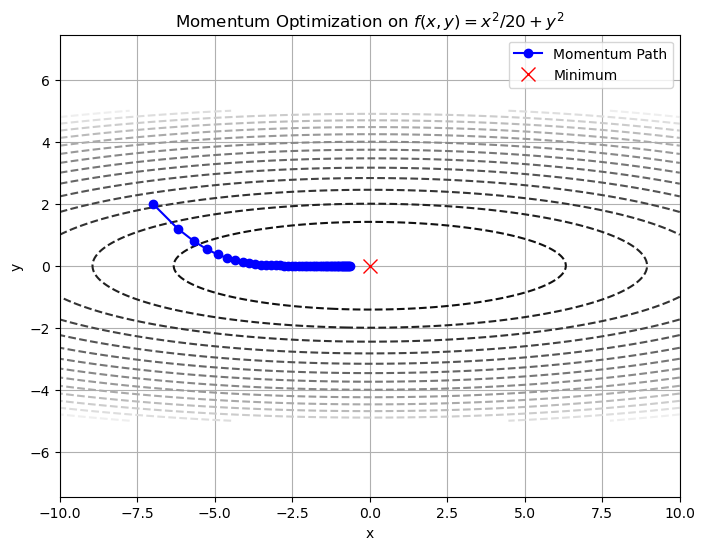

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# 함수 정의 및 수치 미분
def function_2(params):
    x, y = params['x']
    return (x ** 2) / 20 + y ** 2

def numerical_gradient(f, params):
    h = 1e-4
    grad = {}
    x = params['x']
    grad['x'] = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(params)

        x[idx] = tmp_val - h
        fxh2 = f(params)

        grad['x'][idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

# 초기화
init_pos = np.array([-7.0, 2.0])
params = {'x': init_pos.copy()}
optimizer = AdaGrad(lr=0.8)

x_history = []

# 최적화 루프
for _ in range(50):
    x_history.append(params['x'].copy())
    grads = numerical_gradient(function_2, params)
    optimizer.update(params, grads)

x_history = np.array(x_history)

# 등고선 그리기
x = np.linspace(-10, 10, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = (X ** 2) / 20 + Y ** 2

plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=15, cmap='gray', linestyles='dashed')
plt.plot(x_history[:, 0], x_history[:, 1], 'o-', color='blue', label='Momentum Path')
plt.plot(0, 0, 'rx', markersize=10, label='Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Momentum Optimization on $f(x, y) = x^2/20 + y^2$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [49]:
class Adam:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.m = None
        self.v = None
        self.t = 0
        
    def update(self, params, grads):
        if self.m == None:
            self.m = {}
            for key, param in params.items():
                self.m[key] = np.zeros_like(param)
        if self.v == None:
            self.v = {}
            for key, param in params.items():
                self.v[key] = np.zeros_like(param)
        
        self.t += 1
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1 - self.beta1)*grads[key]
            self.v[key] = self.beta2*self.v[key] + (1 - self.beta2)*(grads[key]*grads[key])
            
            m_hat = self.m[key] / (1 - self.beta1**self.t)
            v_hat = self.v[key] / (1 - self.beta2**self.t)
            params[key] -= (self.lr / (np.sqrt(v_hat + 1e-7))) * m_hat

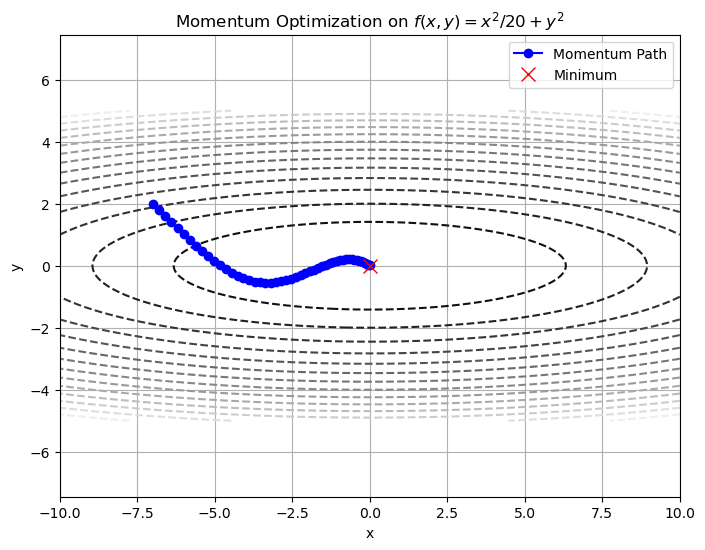

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# 함수 정의 및 수치 미분
def function_2(params):
    x, y = params['x']
    return (x ** 2) / 20 + y ** 2

def numerical_gradient(f, params):
    h = 1e-4
    grad = {}
    x = params['x']
    grad['x'] = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(params)

        x[idx] = tmp_val - h
        fxh2 = f(params)

        grad['x'][idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad

# 초기화
init_pos = np.array([-7.0, 2.0])
params = {'x': init_pos.copy()}
optimizer = Adam(lr=0.2)

x_history = []

# 최적화 루프
for _ in range(50):
    x_history.append(params['x'].copy())
    grads = numerical_gradient(function_2, params)
    optimizer.update(params, grads)

x_history = np.array(x_history)

# 등고선 그리기
x = np.linspace(-10, 10, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = (X ** 2) / 20 + Y ** 2

plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=15, cmap='gray', linestyles='dashed')
plt.plot(x_history[:, 0], x_history[:, 1], 'o-', color='blue', label='Momentum Path')
plt.plot(0, 0, 'rx', markersize=10, label='Minimum')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Momentum Optimization on $f(x, y) = x^2/20 + y^2$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [51]:
import numpy as np
from dataset.mnist import load_mnist
from math import ceil



(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
lr = 0.05

optimizers = {
    "SGD": SGD(lr),
    "Momentum": Momentum(lr),
    "Adagrad": AdaGrad(lr),
    "Adam": Adam(lr)
}

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

loss_histories = {}
train_loss_list = []

iter_per_epoch = ceil(train_size / batch_size)
epochs_num = ceil(iters_num / iter_per_epoch)

def shuffle_data(x, t):
    x_dim = x.shape[1]
    xt_concat = np.concatenate([x, t], axis=1)
    
    np.random.shuffle(xt_concat)
    
    x_shuffled = xt_concat[:, :x_dim]
    t_shuffled = xt_concat[:, x_dim:]
    
    return x_shuffled, t_shuffled


for optim in optimizers.keys():
    network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
    optimizer = optimizers[optim]
    
    train_loss_list = []
    loss = network.loss(x_train[:batch_size], t_train[:batch_size])
    train_loss_list.append(loss)
    
    cur_iter = 1
    for epoch in range(epochs_num):
        # 셔플
        x_train_shuffled, t_train_shuffled = shuffle_data(x_train, t_train)
        offset = 0

        # 배치 수
        for i in range(iter_per_epoch):
            if cur_iter > iters_num:
                break  # iteration 수를 채우면 종료

            # 미니배치 추출
            x_batch = x_train_shuffled[offset:offset+batch_size]
            t_batch = t_train_shuffled[offset:offset+batch_size]

            grads = network.gradient(x_batch, t_batch)
            loss = network.loss(x_batch, t_batch)
            
            if cur_iter%100 == 0:
                print(f"| epoch {epoch} | iter {cur_iter}/{iters_num} | loss: {loss:.4f} |")
            if cur_iter%10 == 0:
                train_loss_list.append(loss)

            optimizer.update(network.params, grads)

            cur_iter += 1
            offset += batch_size

        if cur_iter > iters_num:
            break  # 에폭 루프도 종료
        
    loss_histories[optim] = train_loss_list

| epoch 0 | iter 100/2000 | loss: 2.1327 |
| epoch 0 | iter 200/2000 | loss: 1.1026 |
| epoch 0 | iter 300/2000 | loss: 0.7097 |
| epoch 0 | iter 400/2000 | loss: 0.7142 |
| epoch 0 | iter 500/2000 | loss: 0.4386 |
| epoch 0 | iter 600/2000 | loss: 0.6771 |
| epoch 1 | iter 700/2000 | loss: 0.3874 |
| epoch 1 | iter 800/2000 | loss: 0.3636 |
| epoch 1 | iter 900/2000 | loss: 0.4091 |
| epoch 1 | iter 1000/2000 | loss: 0.3595 |
| epoch 1 | iter 1100/2000 | loss: 0.3617 |
| epoch 1 | iter 1200/2000 | loss: 0.2925 |
| epoch 2 | iter 1300/2000 | loss: 0.2897 |
| epoch 2 | iter 1400/2000 | loss: 0.2770 |
| epoch 2 | iter 1500/2000 | loss: 0.2918 |
| epoch 2 | iter 1600/2000 | loss: 0.3491 |
| epoch 2 | iter 1700/2000 | loss: 0.3791 |
| epoch 2 | iter 1800/2000 | loss: 0.2121 |
| epoch 3 | iter 1900/2000 | loss: 0.2172 |
| epoch 3 | iter 2000/2000 | loss: 0.2726 |
| epoch 0 | iter 100/2000 | loss: 0.3616 |
| epoch 0 | iter 200/2000 | loss: 0.4924 |
| epoch 0 | iter 300/2000 | loss: 0.2892 |


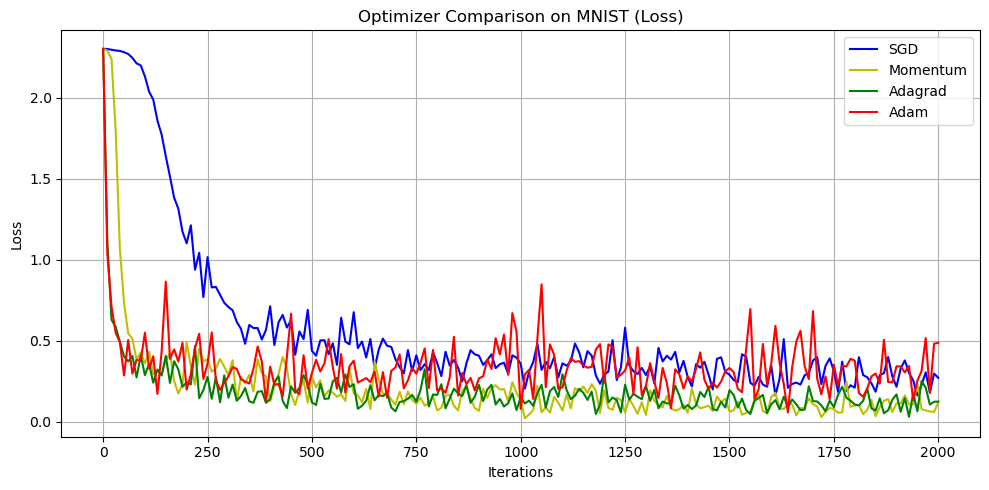

In [52]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['b', 'y', 'g', 'r']  # 색상 목록
x = np.arange(0, iters_num + 1, 10)

plt.figure(figsize=(10, 5))
for idx, key in enumerate(loss_histories):
    color = colors[idx % len(colors)]  # 색상 순환
    plt.plot(x, loss_histories[key], label=key, color=color)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Optimizer Comparison on MNIST (Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


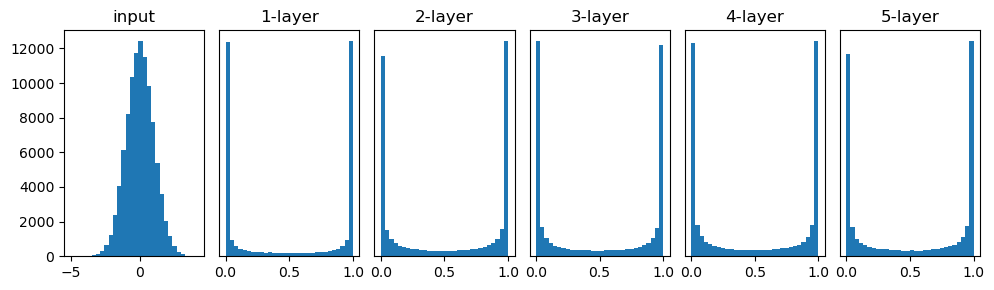

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from util import sigmoid

x = np.random.randn(1000, 100)
hidden_size = 100
layer_num = 5

W = np.random.randn(hidden_size, hidden_size)
B = np.random.randn(hidden_size) * 0

activation_res = [x]

for i in range(layer_num):
    y = sigmoid(np.dot(x, W) + B)
    activation_res.append(y)
    x = y

# 전체 subplot 수 설정
plt.figure(figsize=(10, 3))
for i, a in enumerate(activation_res):
    plt.subplot(1, len(activation_res), i + 1)

    # 타이틀 설정
    plt.title("input" if i == 0 else f"{i}-layer")

    # y축 눈금 제거
    if i != 0:
        plt.yticks([], [])

    # 히스토그램 그리기: input은 자동 범위, 나머지는 [0, 1]
    if i == 0:
        plt.hist(a.flatten(), bins=30)
    else:
        plt.hist(a.flatten(), bins=30, range=(0, 1))

plt.tight_layout()
plt.show()


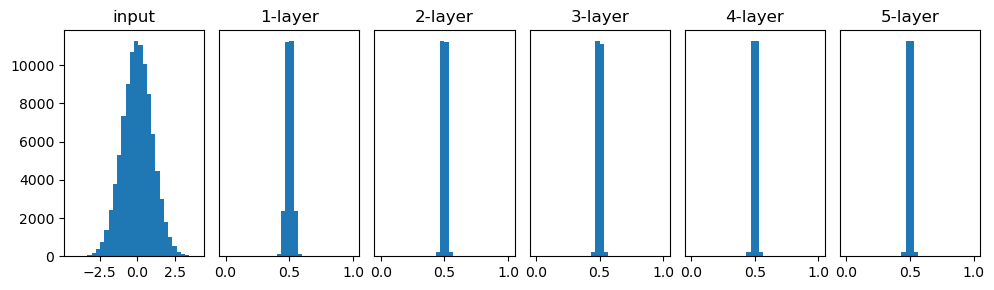

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from util import sigmoid

x = np.random.randn(1000, 100)
hidden_size = 100
layer_num = 5

W = np.random.randn(hidden_size, hidden_size) * 0.01
B = np.random.randn(hidden_size) * 0

activation_res = [x]

for i in range(layer_num):
    y = sigmoid(np.dot(x, W) + B)
    activation_res.append(y)
    x = y

# 전체 subplot 수 설정
plt.figure(figsize=(10, 3))
for i, a in enumerate(activation_res):
    plt.subplot(1, len(activation_res), i + 1)

    # 타이틀 설정
    plt.title("input" if i == 0 else f"{i}-layer")

    # y축 눈금 제거
    if i != 0:
        plt.yticks([], [])

    # 히스토그램 그리기: input은 자동 범위, 나머지는 [0, 1]
    if i == 0:
        plt.hist(a.flatten(), bins=30)
    else:
        plt.hist(a.flatten(), bins=30, range=(0, 1))

plt.tight_layout()
plt.show()


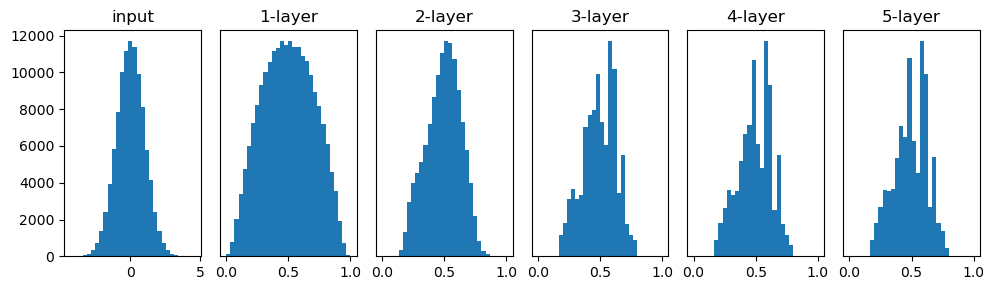

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from util import sigmoid

x = np.random.randn(1000, 100)
hidden_size = 100
layer_num = 5

W = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
B = np.random.randn(hidden_size) * 0

activation_res = [x]

for i in range(layer_num):
    y = sigmoid(np.dot(x, W) + B)
    activation_res.append(y)
    x = y

# 전체 subplot 수 설정
plt.figure(figsize=(10, 3))
for i, a in enumerate(activation_res):
    plt.subplot(1, len(activation_res), i + 1)

    # 타이틀 설정
    plt.title("input" if i == 0 else f"{i}-layer")

    # y축 눈금 제거
    if i != 0:
        plt.yticks([], [])

    # 히스토그램 그리기: input은 자동 범위, 나머지는 [0, 1]
    if i == 0:
        plt.hist(a.flatten(), bins=30)
    else:
        plt.hist(a.flatten(), bins=30, range=(0, 1))

plt.tight_layout()
plt.show()


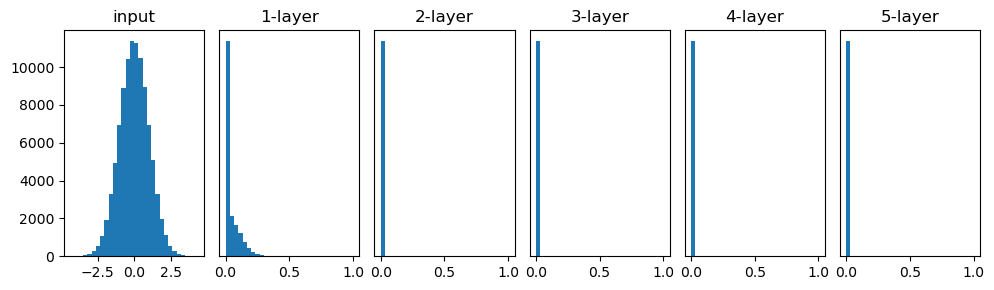

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from util import ReLU

x = np.random.randn(1000, 100)
hidden_size = 100
layer_num = 5

W = np.random.randn(hidden_size, hidden_size) * 0.01
B = np.random.randn(hidden_size) * 0

activation_res = [x]

for i in range(layer_num):
    y = ReLU(np.dot(x, W) + B)
    activation_res.append(y)
    x = y

# 전체 subplot 수 설정
plt.figure(figsize=(10, 3))
for i, a in enumerate(activation_res):
    plt.subplot(1, len(activation_res), i + 1)

    # 타이틀 설정
    plt.title("input" if i == 0 else f"{i}-layer")

    # y축 눈금 제거
    if i != 0:
        plt.yticks([], [])

    # 히스토그램 그리기: input은 자동 범위, 나머지는 [0, 1]
    if i == 0:
        plt.hist(a.flatten(), bins=30)
    else:
        plt.hist(a.flatten(), bins=30, range=(0, 1))

plt.tight_layout()
plt.show()


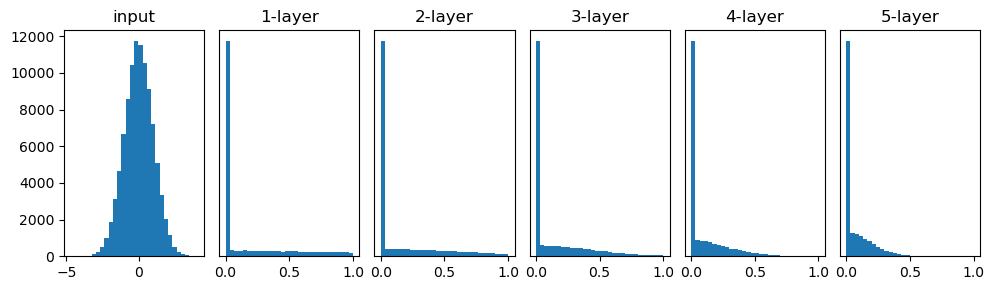

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from util import ReLU

x = np.random.randn(1000, 100)
hidden_size = 100
layer_num = 5

W = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
B = np.random.randn(hidden_size) * 0

activation_res = [x]

for i in range(layer_num):
    y = ReLU(np.dot(x, W) + B)
    activation_res.append(y)
    x = y

# 전체 subplot 수 설정
plt.figure(figsize=(10, 3))
for i, a in enumerate(activation_res):
    plt.subplot(1, len(activation_res), i + 1)

    # 타이틀 설정
    plt.title("input" if i == 0 else f"{i}-layer")

    # y축 눈금 제거
    if i != 0:
        plt.yticks([], [])

    # 히스토그램 그리기: input은 자동 범위, 나머지는 [0, 1]
    if i == 0:
        plt.hist(a.flatten(), bins=30)
    else:
        plt.hist(a.flatten(), bins=30, range=(0, 1))

plt.tight_layout()
plt.show()


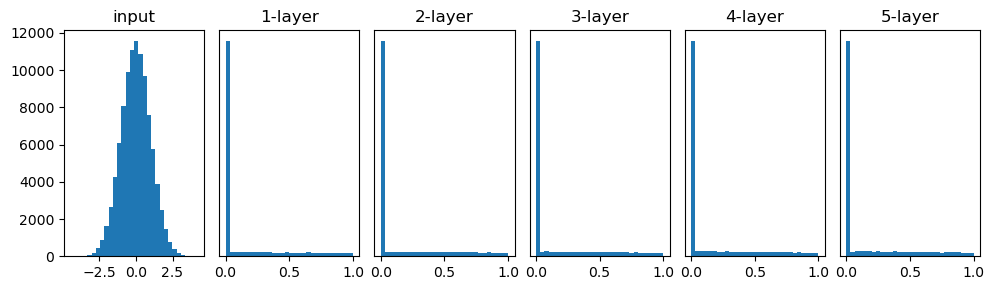

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from util import ReLU

x = np.random.randn(1000, 100)
hidden_size = 100
layer_num = 5

W = np.random.randn(hidden_size, hidden_size) * np.sqrt(2/hidden_size)
B = np.random.randn(hidden_size) * 0

activation_res = [x]

for i in range(layer_num):
    y = ReLU(np.dot(x, W) + B)
    activation_res.append(y)
    x = y

# 전체 subplot 수 설정
plt.figure(figsize=(10, 3))
for i, a in enumerate(activation_res):
    plt.subplot(1, len(activation_res), i + 1)

    # 타이틀 설정
    plt.title("input" if i == 0 else f"{i}-layer")

    
    # y축 눈금 제거
    if i != 0:
        plt.yticks([], [])

    # 히스토그램 그리기: input은 자동 범위, 나머지는 [0, 1]
    if i == 0:
        plt.hist(a.flatten(), bins=30)
    else:
        plt.hist(a.flatten(), bins=30, range=(0, 1))

plt.tight_layout()
plt.show()


In [148]:
import numpy as np
from collections import OrderedDict
from util import ReLU, softmax, CEE, gradient




class ReLU:
    def __init__(self):
        self.x = None
        
    def forward(self, x):
        self.x = x
        return (x > 0)*x
    
    def backward(self, dz):
        return dz*(self.x > 0).astype(int)
    
class Sigmoid:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x):
        self.x = x
        self.y = 1 / (1 + np.exp(-self.x))
        return self.y
    
    def backward(self, dz):
        return dz * self.y *(1 - self.y)
    
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.X = None 
        
    def forward(self, X):
        self.X = X        
        return np.dot(X, self.W) + self.b
    
    def backward(self, dz):
        grads = {}
        grads["W"] = np.dot(self.X.T, dz)
        grads["X"] = np.dot(dz, self.W.T)
        grads["b"] = np.sum(dz, axis=0)
        
        return grads

class Softmax_with_Loss:
    def __init__(self):
        self.y = None
        self.t = None
        
    def forward(self, X, t):
        self.y = softmax(X)
        self.t = t
        loss = CEE(self.y, self.t)
        
        return loss
    
    def backward(self):
        batch_size = self.t.shape[0]
        return (self.y - self.t) / batch_size
    
class FiveLayerNet:
    def __init__(self, input_size, hidden_size, output_size, init_method="normal"):
        self.params = {}
        
        if init_method == "Xavier":
            self.std_input = 1/np.sqrt(input_size)
            self.std_hidden = 1/np.sqrt(hidden_size)
        elif init_method == "He":
            self.std_input = np.sqrt(2/input_size)
            self.std_hidden = np.sqrt(2/hidden_size)
        else:
            self.std_input = 0.01
            self.std_hidden = 0.01
            
        # layer 1
        self.params["W1"] = self.std_input * np.random.randn(input_size,hidden_size)
        self.params["B1"] = np.zeros(hidden_size)
        # layer 2
        self.params["W2"] = self.std_hidden * np.random.randn(hidden_size,hidden_size)
        self.params["B2"] = np.zeros(hidden_size)
        # layer 3
        self.params["W3"] = self.std_hidden * np.random.randn(hidden_size,hidden_size)
        self.params["B3"] = np.zeros(hidden_size)
        # layer 4
        self.params["W4"] = self.std_hidden * np.random.randn(hidden_size,hidden_size)
        self.params["B4"] = np.zeros(hidden_size)
        # layer 5
        self.params["W5"] = self.std_hidden * np.random.randn(hidden_size,output_size)
        self.params["B5"] = np.zeros(output_size)
        
        self.layer = OrderedDict()
        self.layer["Affine1"] = Affine(self.params["W1"], self.params["B1"])
        self.layer["ReLU1"] = ReLU()
        self.layer["Affine2"] = Affine(self.params["W2"], self.params["B2"])
        self.layer["ReLU2"] = ReLU()
        self.layer["Affine3"] = Affine(self.params["W3"], self.params["B3"])
        self.layer["ReLU3"] = ReLU()
        self.layer["Affine4"] = Affine(self.params["W4"], self.params["B4"])
        self.layer["ReLU4"] = ReLU()
        self.layer["Affine5"] = Affine(self.params["W5"], self.params["B5"])
        
        self.last_layer = Softmax_with_Loss()
        
    def predict(self, X):
        h = self.layer["Affine1"].forward(X)
        h = self.layer["ReLU1"].forward(h)
        h = self.layer["Affine2"].forward(h)
        h = self.layer["ReLU2"].forward(h)
        h = self.layer["Affine3"].forward(h)
        h = self.layer["ReLU3"].forward(h)
        h = self.layer["Affine4"].forward(h)
        h = self.layer["ReLU4"].forward(h)
        y = self.layer["Affine5"].forward(h)
        
        return y
        
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.last_layer.forward(y, t)
        return loss
    
    def accuracy(self, x, t):
        Y = self.predict(x)
        predict_label = np.argmax(Y, axis=1)
        target_label = np.argmax(t, axis=1)
        return np.sum(predict_label == target_label) / len(predict_label)
    
    def numerical_gradient(self, x, t):
        grads = {}

        for key in self.params:
            original_param = self.params[key]

            def loss_func(param):
                self.params[key][...] = param
                y = self.predict(x)
                return self.last_layer.forward(y, t)

            h = 1e-4
            shape = original_param.shape
            param_flat = original_param.reshape(-1)
            grad = np.zeros_like(param_flat)

            for i in range(len(param_flat)):
                tmp_val = param_flat[i]

                param_flat[i] = tmp_val + h
                fxh1 = loss_func(param_flat.reshape(shape))

                param_flat[i] = tmp_val - h
                fxh2 = loss_func(param_flat.reshape(shape))

                grad[i] = (fxh1 - fxh2) / (2 * h)

                param_flat[i] = tmp_val

            grads[key] = grad.reshape(shape)
            #self.params[key] = original_param
        return grads
    
    def gradient(self, x, t):
        loss = self.loss(x, t)
        grads = {}
        
        dout = self.last_layer.backward()
        temp_grads = self.layer["Affine5"].backward(dout)
        grads["W5"] = temp_grads["W"]
        grads["B5"] = temp_grads["b"]
        dout = temp_grads["X"]
        
        dout = self.layer["ReLU4"].backward(dout)
        
        temp_grads = self.layer["Affine4"].backward(dout)
        grads["W4"] = temp_grads["W"]
        grads["B4"] = temp_grads["b"]
        
        dout = self.layer["ReLU3"].backward(dout)
        
        temp_grads = self.layer["Affine3"].backward(dout)
        grads["W3"] = temp_grads["W"]
        grads["B3"] = temp_grads["b"]
        
        dout = self.layer["ReLU2"].backward(dout)
        
        temp_grads = self.layer["Affine2"].backward(dout)
        grads["W2"] = temp_grads["W"]
        grads["B2"] = temp_grads["b"]
        
        dout = self.layer["ReLU1"].backward(dout)
        
        temp_grads = self.layer["Affine1"].backward(dout)
        grads["W1"] = temp_grads["W"]
        grads["B1"] = temp_grads["b"]
        
        return grads

In [ ]:
import numpy as np
from dataset.mnist import load_mnist
from math import ceil

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
lr = 0.05

init_methods = ["normal", "Xavier", "He"]

loss_histories = {}
train_loss_list = []

iter_per_epoch = ceil(train_size / batch_size)
epochs_num = ceil(iters_num / iter_per_epoch)

def shuffle_data(x, t):
    x_dim = x.shape[1]
    xt_concat = np.concatenate([x, t], axis=1)
    
    np.random.shuffle(xt_concat)
    
    x_shuffled = xt_concat[:, :x_dim]
    t_shuffled = xt_concat[:, x_dim:]
    
    return x_shuffled, t_shuffled


for init_method in init_methods:
    network = FiveLayerNet(input_size=784, hidden_size=50, output_size=10, init_method=init_method)
    optimizer = SGD(lr)
    
    train_loss_list = []

    loss = network.loss(x_train[:batch_size], t_train[:batch_size])
    train_loss_list.append(loss)
        
    cur_iter = 1
    for epoch in range(epochs_num):
        # 셔플
        x_train_shuffled, t_train_shuffled = shuffle_data(x_train, t_train)
        offset = 0

        # 배치 수
        for i in range(iter_per_epoch):
            if cur_iter > iters_num:
                break  # iteration 수를 채우면 종료

            # 미니배치 추출
            x_batch = x_train_shuffled[offset:offset+batch_size]
            t_batch = t_train_shuffled[offset:offset+batch_size]

            grads = network.gradient(x_batch, t_batch)
            loss = network.loss(x_batch, t_batch)
            if cur_iter%100 == 0:
                print(f"| epoch {epoch} | iter {cur_iter}/{iters_num} | loss: {loss:.4f} |")
            if cur_iter%10 == 0:
                train_loss_list.append(loss)

            optimizer.update(network.params, grads)

            cur_iter += 1
            offset += batch_size

        if cur_iter > iters_num:
            break  # 에폭 루프도 종료
        
    loss_histories[init_method] = train_loss_list

| epoch 0 | iter 100/2000 | loss: 2.3051 |
| epoch 0 | iter 200/2000 | loss: 2.3008 |
| epoch 0 | iter 300/2000 | loss: 2.2988 |
| epoch 0 | iter 400/2000 | loss: 2.2948 |
| epoch 0 | iter 500/2000 | loss: 2.3091 |
| epoch 0 | iter 600/2000 | loss: 2.3069 |
| epoch 1 | iter 700/2000 | loss: 2.3073 |
| epoch 1 | iter 800/2000 | loss: 2.3005 |
| epoch 1 | iter 900/2000 | loss: 2.2928 |
| epoch 1 | iter 1000/2000 | loss: 2.2956 |
| epoch 1 | iter 1100/2000 | loss: 2.2989 |
| epoch 1 | iter 1200/2000 | loss: 2.2927 |
| epoch 2 | iter 1300/2000 | loss: 2.3001 |
| epoch 2 | iter 1400/2000 | loss: 2.3081 |
| epoch 2 | iter 1500/2000 | loss: 2.3058 |
| epoch 2 | iter 1600/2000 | loss: 2.3050 |
| epoch 2 | iter 1700/2000 | loss: 2.2471 |
| epoch 2 | iter 1800/2000 | loss: 2.0546 |
| epoch 3 | iter 1900/2000 | loss: 1.9365 |
| epoch 3 | iter 2000/2000 | loss: 1.9448 |
| epoch 0 | iter 100/2000 | loss: 2.1380 |
| epoch 0 | iter 200/2000 | loss: 1.1629 |
| epoch 0 | iter 300/2000 | loss: 0.8028 |


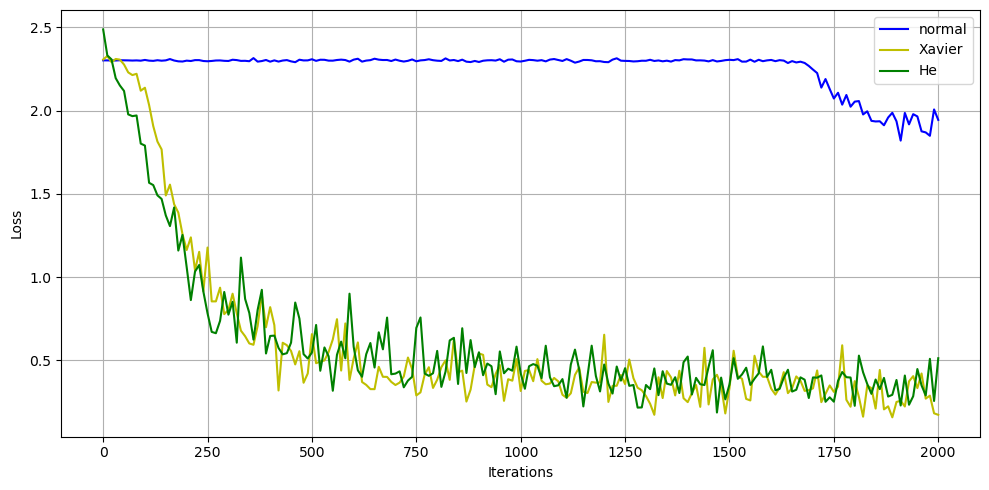

In [60]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['b', 'y', 'g', 'r']  # 색상 목록
x = np.arange(0, iters_num + 1, 10)

plt.figure(figsize=(10, 5))
for idx, key in enumerate(loss_histories):
    color = colors[idx % len(colors)]  # 색상 순환
    plt.plot(x, loss_histories[key], label=key, color=color)

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
class BatchNorm:
    def __init__(self, size, momentum=0.9, eps=1e-7):
        self.gamma = np.ones(size)
        self.beta = np.zeros(size)
        self.momentum = momentum
        self.eps = eps

        self.running_mean = np.zeros(size)
        self.running_var = np.zeros(size)

    def forward(self, x, train_flg=True):
        if train_flg:
            mu = x.mean(axis=0)
            var = x.var(axis=0)
            std = np.sqrt(var + self.eps)
            self.x_centered = x - mu
            self.std_inv = 1 / std
            self.x_norm = self.x_centered * self.std_inv

            out = self.gamma * self.x_norm + self.beta

            # update running stats
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            x_norm = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            out = self.gamma * x_norm + self.beta

        return out

    def backward(self, dout):
        N, D = dout.shape
        dbeta = np.sum(dout, axis=0)
        dgamma = np.sum(self.x_norm * dout, axis=0)
        dx_norm = dout * self.gamma

        dvar = np.sum(dx_norm * self.x_centered, axis=0) * -0.5 * self.std_inv**3
        dmu = np.sum(dx_norm * -self.std_inv, axis=0) + dvar * np.mean(-2. * self.x_centered, axis=0)

        dx = (dx_norm * self.std_inv) + (dvar * 2 * self.x_centered / N) + (dmu / N)

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx

In [ ]:
class FiveLayerNetWithBatchNorm(FiveLayerNet):
    def __init__(self, input_size, hidden_size, output_size, init_method="normal"):
        super().__init__(input_size, hidden_size, output_size, init_method)

        self.bn_layers = OrderedDict()
        self.bn_layers["BN1"] = BatchNorm(hidden_size)
        self.bn_layers["BN2"] = BatchNorm(hidden_size)
        self.bn_layers["BN3"] = BatchNorm(hidden_size)
        self.bn_layers["BN4"] = BatchNorm(hidden_size)

        # 순서 수정: Affine → BN → ReLU
        self.layer = OrderedDict()
        self.layer["Affine1"] = Affine(self.params["W1"], self.params["B1"])
        self.layer["BN1"] = self.bn_layers["BN1"]
        self.layer["ReLU1"] = ReLU()
        self.layer["Affine2"] = Affine(self.params["W2"], self.params["B2"])
        self.layer["BN2"] = self.bn_layers["BN2"]
        self.layer["ReLU2"] = ReLU()
        self.layer["Affine3"] = Affine(self.params["W3"], self.params["B3"])
        self.layer["BN3"] = self.bn_layers["BN3"]
        self.layer["ReLU3"] = ReLU()
        self.layer["Affine4"] = Affine(self.params["W4"], self.params["B4"])
        self.layer["BN4"] = self.bn_layers["BN4"]
        self.layer["ReLU4"] = ReLU()
        self.layer["Affine5"] = Affine(self.params["W5"], self.params["B5"])
        self.last_layer = Softmax_with_Loss()
        
    def predict(self, X, train_flg=True):
        h = X
        for key, layer in self.layer.items():
            if "BN" in key:
                h = layer.forward(h, train_flg)
            else:
                h = layer.forward(h)
        return h
    def gradient(self, x, t):
        grads = {}
        loss = self.loss(x, t)
        dout = self.last_layer.backward()
    
        # 역방향 순회
        layers = list(self.layer.items())
        layers.reverse()
    
        for key, layer in layers:
            if "ReLU" in key or "Affine" in key:
                dout = layer.backward(dout)
                if "Affine" in key:
                    idx = key[-1]
                    grads[f"W{idx}"] = layer.W
                    grads[f"B{idx}"] = layer.b
            elif "BN" in key:
                dout = layer.backward(dout)
                idx = key[-1]
                grads[f"gamma{idx}"] = layer.dgamma
                grads[f"beta{idx}"] = layer.dbeta
    
        return grads

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from dataset.mnist import load_mnist
from layer import ReLU

class FiveLayerNet:
    def __init__(self, input_size, hidden_size, output_size, init_method="normal"):
        self.params = {}
        
        if init_method == "Xavier":
            self.std_input = 1/np.sqrt(input_size)
            self.std_hidden = 1/np.sqrt(hidden_size)
        elif init_method == "He":
            self.std_input = np.sqrt(2/input_size)
            self.std_hidden = np.sqrt(2/hidden_size)
        else:
            self.std_input = 0.01
            self.std_hidden = 0.01
            
        # layer 1
        self.params["W1"] = self.std_input * np.random.randn(input_size,hidden_size)
        self.params["B1"] = np.zeros(hidden_size)
        # layer 2
        self.params["W2"] = self.std_hidden * np.random.randn(hidden_size,hidden_size)
        self.params["B2"] = np.zeros(hidden_size)
        # layer 3
        self.params["W3"] = self.std_hidden * np.random.randn(hidden_size,hidden_size)
        self.params["B3"] = np.zeros(hidden_size)
        # layer 4
        self.params["W4"] = self.std_hidden * np.random.randn(hidden_size,hidden_size)
        self.params["B4"] = np.zeros(hidden_size)
        # layer 5
        self.params["W5"] = self.std_hidden * np.random.randn(hidden_size,output_size)
        self.params["B5"] = np.zeros(output_size)
        
        self.layer = OrderedDict()
        self.layer["Affine1"] = Affine(self.params["W1"], self.params["B1"])
        self.layer["ReLU1"] = ReLU()
        self.layer["Affine2"] = Affine(self.params["W2"], self.params["B2"])
        self.layer["ReLU2"] = ReLU()
        self.layer["Affine3"] = Affine(self.params["W3"], self.params["B3"])
        self.layer["ReLU3"] = ReLU()
        self.layer["Affine4"] = Affine(self.params["W4"], self.params["B4"])
        self.layer["ReLU4"] = ReLU()
        self.layer["Affine5"] = Affine(self.params["W5"], self.params["B5"])
        
        self.last_layer = Softmax_with_Loss()
        
    def predict(self, X):
        h = self.layer["Affine1"].forward(X)
        h = self.layer["ReLU1"].forward(h)
        h = self.layer["Affine2"].forward(h)
        h = self.layer["ReLU2"].forward(h)
        h = self.layer["Affine3"].forward(h)
        h = self.layer["ReLU3"].forward(h)
        h = self.layer["Affine4"].forward(h)
        h = self.layer["ReLU4"].forward(h)
        y = self.layer["Affine5"].forward(h)
        
        return y
        
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.last_layer.forward(y, t)
        return loss
    
    def accuracy(self, x, t):
        Y = self.predict(x)
        predict_label = np.argmax(Y, axis=1)
        target_label = np.argmax(t, axis=1)
        return np.sum(predict_label == target_label) / len(predict_label)
    
    def numerical_gradient(self, x, t):
        grads = {}

        for key in self.params:
            original_param = self.params[key]

            def loss_func(param):
                self.params[key][...] = param
                y = self.predict(x)
                return self.last_layer.forward(y, t)

            h = 1e-4
            shape = original_param.shape
            param_flat = original_param.reshape(-1)
            grad = np.zeros_like(param_flat)

            for i in range(len(param_flat)):
                tmp_val = param_flat[i]

                param_flat[i] = tmp_val + h
                fxh1 = loss_func(param_flat.reshape(shape))

                param_flat[i] = tmp_val - h
                fxh2 = loss_func(param_flat.reshape(shape))

                grad[i] = (fxh1 - fxh2) / (2 * h)

                param_flat[i] = tmp_val

            grads[key] = grad.reshape(shape)
            #self.params[key] = original_param
        return grads
    
    def gradient(self, x, t):
        loss = self.loss(x, t)
        grads = {}
        
        dout = self.last_layer.backward()
        temp_grads = self.layer["Affine5"].backward(dout)
        grads["W5"] = temp_grads["W"]
        grads["B5"] = temp_grads["b"]
        dout = temp_grads["X"]
        
        dout = self.layer["ReLU4"].backward(dout)
        
        temp_grads = self.layer["Affine4"].backward(dout)
        grads["W4"] = temp_grads["W"]
        grads["B4"] = temp_grads["b"]
        
        dout = self.layer["ReLU3"].backward(dout)
        
        temp_grads = self.layer["Affine3"].backward(dout)
        grads["W3"] = temp_grads["W"]
        grads["B3"] = temp_grads["b"]
        
        dout = self.layer["ReLU2"].backward(dout)
        
        temp_grads = self.layer["Affine2"].backward(dout)
        grads["W2"] = temp_grads["W"]
        grads["B2"] = temp_grads["b"]
        
        dout = self.layer["ReLU1"].backward(dout)
        
        temp_grads = self.layer["Affine1"].backward(dout)
        grads["W1"] = temp_grads["W"]
        grads["B1"] = temp_grads["b"]
        
        return grads
    
class BatchNorm:
    def __init__(self, size, momentum=0.9, eps=1e-7):
        self.gamma = np.ones(size)
        self.beta = np.zeros(size)
        self.momentum = momentum
        self.eps = eps

        self.running_mean = np.zeros(size)
        self.running_var = np.zeros(size)

    def forward(self, x, train_flg=True):
        if train_flg:
            mu = x.mean(axis=0)
            var = x.var(axis=0)
            std = np.sqrt(var + self.eps)
            self.x_centered = x - mu
            self.std_inv = 1 / std
            self.x_norm = self.x_centered * self.std_inv

            out = self.gamma * self.x_norm + self.beta

            # update running stats
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            x_norm = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            out = self.gamma * x_norm + self.beta

        return out

    def backward(self, dout):
        N, D = dout.shape
        dbeta = np.sum(dout, axis=0)
        dgamma = np.sum(self.x_norm * dout, axis=0)
        dx_norm = dout * self.gamma

        dvar = np.sum(dx_norm * self.x_centered, axis=0) * -0.5 * self.std_inv**3
        dmu = np.sum(dx_norm * -self.std_inv, axis=0) + dvar * np.mean(-2. * self.x_centered, axis=0)

        dx = (dx_norm * self.std_inv) + (dvar * 2 * self.x_centered / N) + (dmu / N)

        self.dgamma = dgamma
        self.dbeta = dbeta

        return dx
    
class FiveLayerNetWithBatchNorm(FiveLayerNet):
    def __init__(self, input_size, hidden_size, output_size, init_method="normal"):
        super().__init__(input_size, hidden_size, output_size, init_method)

        self.bn_layers = OrderedDict()
        self.bn_layers["BN1"] = BatchNorm(hidden_size)
        self.bn_layers["BN2"] = BatchNorm(hidden_size)
        self.bn_layers["BN3"] = BatchNorm(hidden_size)
        self.bn_layers["BN4"] = BatchNorm(hidden_size)

        # 순서 수정: Affine → BN → ReLU
        self.layer = OrderedDict()
        self.layer["Affine1"] = Affine(self.params["W1"], self.params["B1"])
        self.layer["BN1"] = self.bn_layers["BN1"]
        self.layer["ReLU1"] = ReLU()
        self.layer["Affine2"] = Affine(self.params["W2"], self.params["B2"])
        self.layer["BN2"] = self.bn_layers["BN2"]
        self.layer["ReLU2"] = ReLU()
        self.layer["Affine3"] = Affine(self.params["W3"], self.params["B3"])
        self.layer["BN3"] = self.bn_layers["BN3"]
        self.layer["ReLU3"] = ReLU()
        self.layer["Affine4"] = Affine(self.params["W4"], self.params["B4"])
        self.layer["BN4"] = self.bn_layers["BN4"]
        self.layer["ReLU4"] = ReLU()
        self.layer["Affine5"] = Affine(self.params["W5"], self.params["B5"])
        self.last_layer = Softmax_with_Loss()
        
    def predict(self, X, train_flg=True):
        h = X
        for key, layer in self.layer.items():
            if "BN" in key:
                h = layer.forward(h, train_flg)
            else:
                h = layer.forward(h)
        return h
    
    def gradient(self, x, t):
        grads = {}
        loss = self.loss(x, t)
        dout = self.last_layer.backward()
    
        # 역방향 순회
        layers = list(self.layer.items())
        layers.reverse()
    
        for key, layer in layers:
            if "ReLU" in key or "Affine" in key:
                grad = layer.backward(dout)
                if "Affine" in key:
                    idx = key[-1]
                    grads[f"W{idx}"] = grad["W"]
                    grads[f"B{idx}"] = grad["b"]
                    dout = grad["X"]
            elif "BN" in key:
                dout = layer.backward(dout)
                idx = key[-1]
                grads[f"gamma{idx}"] = layer.dgamma
                grads[f"beta{idx}"] = layer.dbeta
    
        return grads
    


# 두 모델 학습 루프
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
lr = 0.1
iter_per_epoch = ceil(train_size / batch_size)
epochs_num = 20

def shuffle_data(x, t):
    x_dim = x.shape[1]
    xt_concat = np.concatenate([x, t], axis=1)
    
    np.random.shuffle(xt_concat)
    
    x_shuffled = xt_concat[:, :x_dim]
    t_shuffled = xt_concat[:, x_dim:]
    
    return x_shuffled, t_shuffled

no_batchnorm_net = FiveLayerNet(input_size=784, hidden_size=50, output_size=10)
batchnorm_net = FiveLayerNetWithBatchNorm(input_size=784, hidden_size=50, output_size=10)

optimizer = SGD(lr)
networks = {"no_batchnorm_net": no_batchnorm_net, "batchnorm_net": batchnorm_net}
#train_loss = {"no_batchnorm_net":[], "batchnorm_net":[]}
train_accuracy = {"no_batchnorm_net":[], "batchnorm_net":[]}

accuracy = no_batchnorm_net.accuracy(x_train[:batch_size], t_train[:batch_size])
train_accuracy['no_batchnorm_net'].append(accuracy)
accuracy = batchnorm_net.accuracy(x_train[:batch_size], t_train[:batch_size])
train_accuracy['batchnorm_net'].append(accuracy)

for network_name, network in networks.items():
    cur_iter = 1
    for epoch in range(epochs_num):
        x_train_shuffled, t_train_shuffled = shuffle_data(x_train, t_train)
        offset = 0

        for i in range(iter_per_epoch):
            x_batch = x_train_shuffled[offset:offset+batch_size]
            t_batch = t_train_shuffled[offset:offset+batch_size]

            grads = network.gradient(x_batch, t_batch)
            loss = network.loss(x_batch, t_batch)
            if cur_iter%100 == 0:
                accuracy = network.accuracy(x_train, t_train)
                train_accuracy[network_name].append(accuracy)

            optimizer.update(network.params, grads)

            cur_iter += 1
            offset += batch_size

        print(f"| epoch {epoch} | acc: {accuracy:.4f} |")

| epoch 0 | acc: 0.8491 |
| epoch 1 | acc: 0.8915 |
| epoch 2 | acc: 0.9008 |
| epoch 3 | acc: 0.9149 |
| epoch 4 | acc: 0.9155 |
| epoch 5 | acc: 0.9223 |
| epoch 6 | acc: 0.9227 |
| epoch 7 | acc: 0.9307 |
| epoch 8 | acc: 0.9327 |


KeyboardInterrupt: 

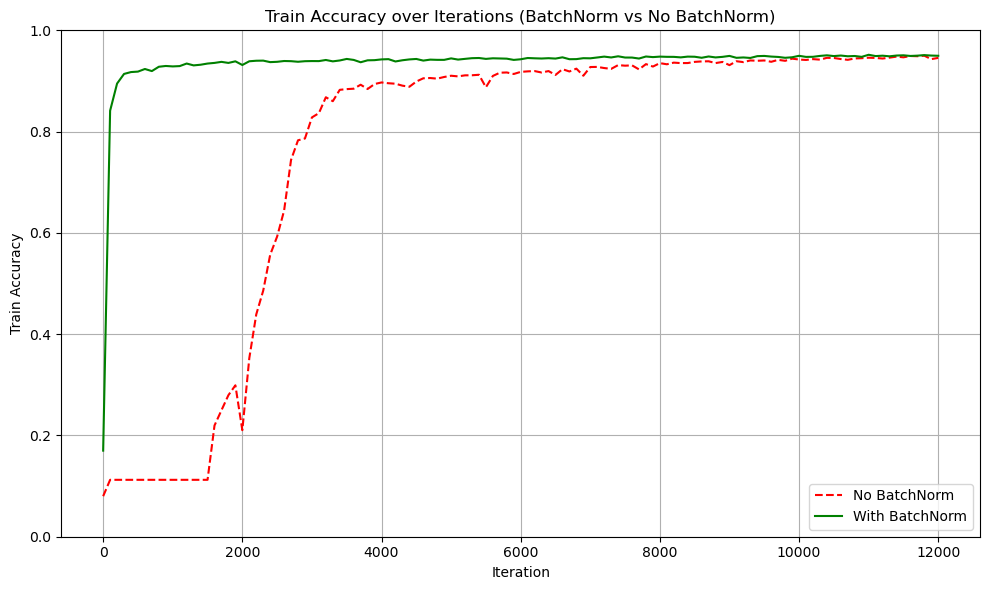

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 정확도 리스트 길이만큼 iterations 생성
iters_recorded = len(train_accuracy["no_batchnorm_net"])
iterations = [0] + list(np.arange(100, 100 * iters_recorded, 100))

plt.figure(figsize=(10, 6))
plt.plot(iterations, train_accuracy["no_batchnorm_net"], label="No BatchNorm", linestyle="--", color="red")
plt.plot(iterations, train_accuracy["batchnorm_net"], label="With BatchNorm", linestyle="-", color="green")

plt.title("Train Accuracy over Iterations (BatchNorm vs No BatchNorm)")
plt.xlabel("Iteration")
plt.ylabel("Train Accuracy")
plt.grid(True)
plt.legend()
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()


In [77]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x_train = x_train[:300]
t_train = t_train[:300]

network = FiveLayerNetWithBatchNorm(input_size=784, hidden_size=50, output_size=10)
optimizer = SGD(lr=0.01)
max_epoch = 201
batch_size = 50
iter_per_epoch = ceil(len(x_train) / batch_size)

def shuffle_data(x, t):
    x_dim = x.shape[1]
    xt_concat = np.concatenate([x, t], axis=1)
    
    np.random.shuffle(xt_concat)
    
    x_shuffled = xt_concat[:, :x_dim]
    t_shuffled = xt_concat[:, x_dim:]
    
    return x_shuffled, t_shuffled

train_accuracy_list = []
test_accuracy_list = []

train_accuracy = network.accuracy(x_train[:batch_size], t_train[:batch_size])
train_accuracy_list.append(train_accuracy)
test_accuracy = network.accuracy(x_test, t_test)
test_accuracy_list.append(test_accuracy)

cur_iter = 1
for epoch in range(max_epoch):
    x_train_shuffled, t_train_shuffled = shuffle_data(x_train, t_train)
    
    offset = 0
    for i in range(iter_per_epoch):
        x_batch = x_train_shuffled[offset:offset+batch_size]
        t_batch = t_train_shuffled[offset:offset+batch_size]
        
        grads = network.gradient(x_batch, t_batch)
        
        
        optimizer.update(network.params, grads)

        cur_iter += 1
        offset += batch_size
    train_accuracy = network.accuracy(x_train, t_train)
    test_accuracy = network.accuracy(x_test, t_test)
    
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    print(f"| epoch {epoch} | train_accuracy : {train_accuracy:.4f} | test_accuracy : {test_accuracy:.4f} |")

| epoch 0 | train_accuracy : 0.6800 | test_accuracy : 0.5105 |
| epoch 1 | train_accuracy : 0.7333 | test_accuracy : 0.5663 |
| epoch 2 | train_accuracy : 0.7433 | test_accuracy : 0.5891 |
| epoch 3 | train_accuracy : 0.7967 | test_accuracy : 0.6103 |
| epoch 4 | train_accuracy : 0.8200 | test_accuracy : 0.5993 |
| epoch 5 | train_accuracy : 0.8133 | test_accuracy : 0.6031 |
| epoch 6 | train_accuracy : 0.8300 | test_accuracy : 0.6196 |
| epoch 7 | train_accuracy : 0.8500 | test_accuracy : 0.6271 |
| epoch 8 | train_accuracy : 0.8600 | test_accuracy : 0.6302 |
| epoch 9 | train_accuracy : 0.8533 | test_accuracy : 0.6242 |
| epoch 10 | train_accuracy : 0.8433 | test_accuracy : 0.6236 |
| epoch 11 | train_accuracy : 0.8567 | test_accuracy : 0.6350 |
| epoch 12 | train_accuracy : 0.8567 | test_accuracy : 0.6321 |
| epoch 13 | train_accuracy : 0.8767 | test_accuracy : 0.6449 |
| epoch 14 | train_accuracy : 0.8900 | test_accuracy : 0.6306 |
| epoch 15 | train_accuracy : 0.8867 | test_accura

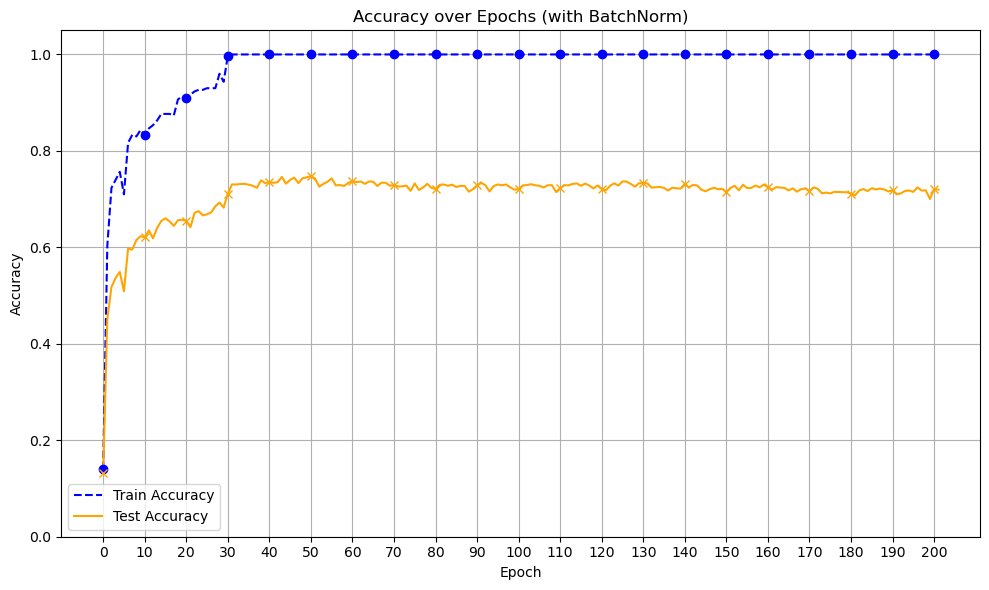

In [68]:
import matplotlib.pyplot as plt
import numpy as np

epochs = list(range(max_epoch + 1))  # 초기 accuracy 포함
interval = 10  # 마커 간격

plt.figure(figsize=(10, 6))

# 전체 라인 그리기 (마커 없이)
plt.plot(epochs, train_accuracy_list, label='Train Accuracy', linestyle='--', color='blue')
plt.plot(epochs, test_accuracy_list, label='Test Accuracy', linestyle='-', color='orange')

# 마커만 10 에폭 간격으로 표시
marker_epochs = np.arange(0, max_epoch + 1, interval)
plt.plot(marker_epochs, [train_accuracy_list[i] for i in marker_epochs], 'o', color='blue')
plt.plot(marker_epochs, [test_accuracy_list[i] for i in marker_epochs], 'x', color='orange')

plt.title('Accuracy over Epochs (with BatchNorm)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.05)
plt.xticks(np.arange(0, max_epoch + 1, 10))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [142]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x_train = x_train[:1000]
t_train = t_train[:1000]

train_size = x_train.shape[0]
batch_size = 100
lr = 0.1
iter_per_epoch = ceil(train_size / batch_size)
epochs_num = 500

def shuffle_data(x, t):
    x_dim = x.shape[1]
    xt_concat = np.concatenate([x, t], axis=1)
    
    np.random.shuffle(xt_concat)
    
    x_shuffled = xt_concat[:, :x_dim]
    t_shuffled = xt_concat[:, x_dim:]
    
    return x_shuffled, t_shuffled

#train_size = x_train.shape[0]
#batch_size = 50
#lr = 0.1
#iter_per_epoch = ceil(train_size / batch_size)
#epochs_num = 201

optimizer = SGD(lr)
network = FiveLayerNet(input_size=784, hidden_size=50, output_size=10)

train_accuracy_list = []
test_accuracy_list = []

train_accuracy = network.accuracy(x_train[:batch_size], t_train[:batch_size])
train_accuracy_list.append(train_accuracy)
test_accuracy = network.accuracy(x_test, t_test)
test_accuracy_list.append(test_accuracy)

cur_iter = 1
for epoch in range(epochs_num):
    x_train_shuffled, t_train_shuffled = shuffle_data(x_train, t_train)
    
    offset = 0
    for i in range(iter_per_epoch):
        x_batch = x_train_shuffled[offset:offset+batch_size]
        t_batch = t_train_shuffled[offset:offset+batch_size]
        
        grads = network.gradient(x_batch, t_batch)
        
        
        optimizer.update(network.params, grads)

        cur_iter += 1
        offset += batch_size
    
    if epoch % 10 == 0:
        train_accuracy = network.accuracy(x_train, t_train)
        test_accuracy = network.accuracy(x_test, t_test)
        
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)
    print(f"| epoch {epoch} | train_accuracy : {train_accuracy:.4f} | test_accuracy : {test_accuracy:.4f} |")

| epoch 0 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 1 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 2 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 3 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 4 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 5 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 6 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 7 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 8 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 9 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 10 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 11 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 12 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 13 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 14 | train_accuracy : 0.1170 | test_accuracy : 0.1028 |
| epoch 15 | train_accuracy : 0.1170 | test_accura

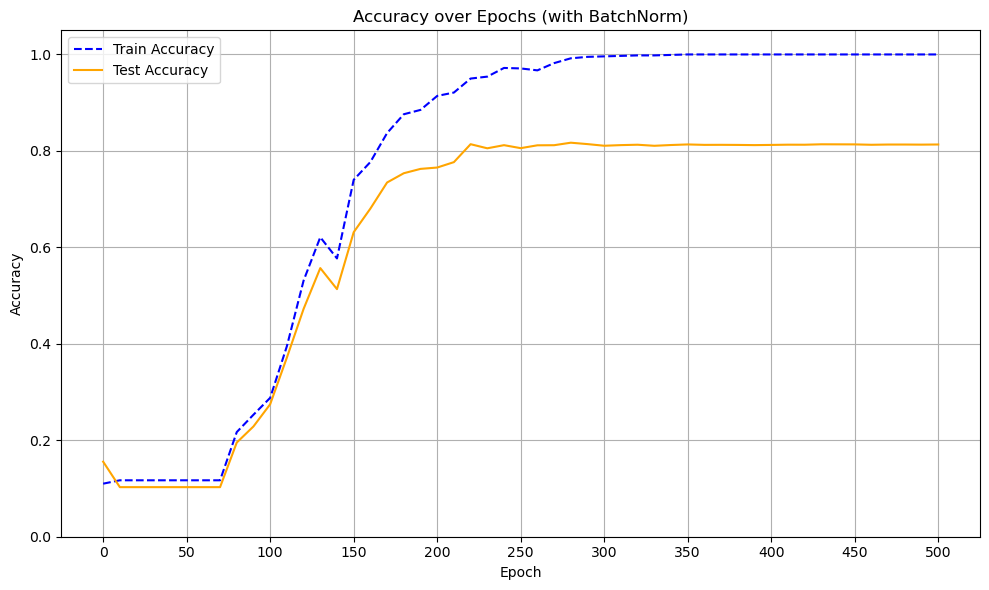

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# epochs 저장 간격에 맞춰서 리스트 생성
epochs = list(range(0, epochs_num + 1, 10))
#interval = 10

plt.figure(figsize=(10, 6))

# 전체 라인 그리기 (마커 없이)
plt.plot(epochs, train_accuracy_list, label='Train Accuracy', linestyle='--', color='blue')
plt.plot(epochs, test_accuracy_list, label='Test Accuracy', linestyle='-', color='orange')

# 마커만 10 에폭 간격으로 표시
#marker_epochs = np.arange(0, epochs_num + 1, interval)
#plt.plot(marker_epochs, [train_accuracy_list[i] for i in marker_epochs], 'o', color='blue')
#plt.plot(marker_epochs, [test_accuracy_list[i] for i in marker_epochs], 'x', color='orange')

plt.title('Accuracy over Epochs (with BatchNorm)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.05)
plt.xticks(np.arange(0, epochs_num + 1, 50))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [137]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg: 
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask.astype(int)
        else:
            return x * (1 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from dataset.mnist import load_mnist
from layer import ReLU
    
class FiveLayerNetWithDropout(FiveLayerNet):
    def __init__(self, input_size, hidden_size, output_size, init_method="normal", dropout_ratio=0.5):
        super().__init__(input_size, hidden_size, output_size, init_method)

        # Dropout 레이어 생성
        self.dropout_layers = OrderedDict()
        self.dropout_layers["Dropout1"] = Dropout(dropout_ratio)
        self.dropout_layers["Dropout2"] = Dropout(dropout_ratio)
        self.dropout_layers["Dropout3"] = Dropout(dropout_ratio)
        self.dropout_layers["Dropout4"] = Dropout(dropout_ratio)

        # 순서 수정: Affine → ReLU → Dropout
        self.layer = OrderedDict()
        self.layer["Affine1"] = Affine(self.params["W1"], self.params["B1"])
        self.layer["ReLU1"] = ReLU()
        self.layer["Dropout1"] = self.dropout_layers["Dropout1"]

        self.layer["Affine2"] = Affine(self.params["W2"], self.params["B2"])
        self.layer["ReLU2"] = ReLU()
        self.layer["Dropout2"] = self.dropout_layers["Dropout2"]

        self.layer["Affine3"] = Affine(self.params["W3"], self.params["B3"])
        self.layer["ReLU3"] = ReLU()
        self.layer["Dropout3"] = self.dropout_layers["Dropout3"]

        self.layer["Affine4"] = Affine(self.params["W4"], self.params["B4"])
        self.layer["ReLU4"] = ReLU()
        self.layer["Dropout4"] = self.dropout_layers["Dropout4"]

        self.layer["Affine5"] = Affine(self.params["W5"], self.params["B5"])
        self.last_layer = Softmax_with_Loss()

    def predict(self, X, train_flg=True):
        h = X
        for key, layer in self.layer.items():
            if "Dropout" in key:
                h = layer.forward(h, train_flg)
            else:
                h = layer.forward(h)
        return h

    def gradient(self, x, t):
        grads = {}
        loss = self.loss(x, t)
        dout = self.last_layer.backward()

        layers = list(self.layer.items())
        layers.reverse()

        for key, layer in layers:
            if "Dropout" in key:
                dout = layer.backward(dout)
            elif "ReLU" in key:
                dout = layer.backward(dout)
            elif "Affine" in key:
                grad = layer.backward(dout)
                idx = key[-1]
                grads[f"W{idx}"] = grad["W"]
                grads[f"B{idx}"] = grad["b"]
                dout = grad["X"]

        return grads
    
    def accuracy(self, x, t):
        Y = self.predict(x, train_flg=False)
        predict_label = np.argmax(Y, axis=1)
        target_label = np.argmax(t, axis=1)
        return np.sum(predict_label == target_label) / len(predict_label)

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
#x_train = x_train[:10000]
#t_train = t_train[:10000]

train_size = x_train.shape[0]
batch_size = 100
lr = 0.1
iter_per_epoch = ceil(train_size / batch_size)
epochs_num = 500

def shuffle_data(x, t):
    x_dim = x.shape[1]
    xt_concat = np.concatenate([x, t], axis=1)
    
    np.random.shuffle(xt_concat)
    
    x_shuffled = xt_concat[:, :x_dim]
    t_shuffled = xt_concat[:, x_dim:]
    
    return x_shuffled, t_shuffled

optimizer = SGD(lr)
network = FiveLayerNetWithDropout(input_size=784, hidden_size=50, output_size=10, init_method="He")

train_accuracy_list = []
test_accuracy_list = []

train_accuracy = network.accuracy(x_train[:batch_size], t_train[:batch_size])
train_accuracy_list.append(train_accuracy)
test_accuracy = network.accuracy(x_test, t_test)
test_accuracy_list.append(test_accuracy)

cur_iter = 1
for epoch in range(epochs_num):
    x_train_shuffled, t_train_shuffled = shuffle_data(x_train, t_train)
    
    offset = 0
    for i in range(iter_per_epoch):
        x_batch = x_train_shuffled[offset:offset+batch_size]
        t_batch = t_train_shuffled[offset:offset+batch_size]
        
        grads = network.gradient(x_batch, t_batch)
        
        
        optimizer.update(network.params, grads)

        cur_iter += 1
        offset += batch_size
    
    if epoch % 10 == 0:
        train_accuracy = network.accuracy(x_train, t_train)
        test_accuracy = network.accuracy(x_test, t_test)
        
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)
    print(f"| epoch {epoch} | train_accuracy : {train_accuracy:.4f} | test_accuracy : {test_accuracy:.4f} |")

| epoch 0 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 1 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 2 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 3 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 4 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 5 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 6 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 7 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 8 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 9 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 10 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 11 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 12 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 13 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 14 | train_accuracy : 0.1124 | test_accuracy : 0.1135 |
| epoch 15 | train_accuracy : 0.1124 | test_accura

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs = list(range(max_epoch + 1))  # 초기 accuracy 포함
interval = 10  # 마커 간격

plt.figure(figsize=(10, 6))

# 전체 라인 그리기 (마커 없이)
plt.plot(epochs, train_accuracy_list, label='Train Accuracy', linestyle='--', color='blue')
plt.plot(epochs, test_accuracy_list, label='Test Accuracy', linestyle='-', color='orange')

# 마커만 10 에폭 간격으로 표시
marker_epochs = np.arange(0, max_epoch + 1, interval)
plt.plot(marker_epochs, [train_accuracy_list[i] for i in marker_epochs], 'o', color='blue')
plt.plot(marker_epochs, [test_accuracy_list[i] for i in marker_epochs], 'x', color='orange')

plt.title('Accuracy over Epochs (with BatchNorm)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.05)
plt.xticks(np.arange(0, max_epoch + 1, 10))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [72]:
class FiveLayerNet:
    def __init__(self, input_size, hidden_size, output_size, std="normal"):
        self.params = {}
        
        if std == "Xavier":
            self.std_input = 1/np.sqrt(input_size)
            self.std_hidden = 1/np.sqrt(hidden_size)
        elif std == "He":
            self.std_input = np.sqrt(2/input_size)
            self.std_hidden = np.sqrt(2/hidden_size)
        else:
            self.std_input = 0.01
            self.std_hidden = 0.01
            
        # layer 1
        self.params["W1"] = self.std_input * np.random.randn(input_size,hidden_size)
        self.params["B1"] = np.zeros(hidden_size)
        # layer 2
        self.params["W2"] = self.std_hidden * np.random.randn(hidden_size,hidden_size)
        self.params["B2"] = np.zeros(hidden_size)
        # layer 3
        self.params["W3"] = self.std_hidden * np.random.randn(hidden_size,hidden_size)
        self.params["B3"] = np.zeros(hidden_size)
        # layer 4
        self.params["W4"] = self.std_hidden * np.random.randn(hidden_size,hidden_size)
        self.params["B4"] = np.zeros(hidden_size)
        # layer 5
        self.params["W5"] = self.std_hidden * np.random.randn(hidden_size,output_size)
        self.params["B5"] = np.zeros(output_size)
        
        self.layer = OrderedDict()
        self.layer["Affine1"] = Affine(self.params["W1"], self.params["B1"])
        self.layer["ReLU1"] = ReLU()
        self.layer["Affine2"] = Affine(self.params["W2"], self.params["B2"])
        self.layer["ReLU2"] = ReLU()
        self.layer["Affine3"] = Affine(self.params["W3"], self.params["B3"])
        self.layer["ReLU3"] = ReLU()
        self.layer["Affine4"] = Affine(self.params["W4"], self.params["B4"])
        self.layer["ReLU4"] = ReLU()
        self.layer["Affine5"] = Affine(self.params["W5"], self.params["B5"])
        
        self.last_layer = Softmax_with_Loss()
        
    def predict(self, X):
        h = self.layer["Affine1"].forward(X)
        h = self.layer["ReLU1"].forward(h)
        h = self.layer["Affine2"].forward(h)
        h = self.layer["ReLU2"].forward(h)
        h = self.layer["Affine3"].forward(h)
        h = self.layer["ReLU3"].forward(h)
        h = self.layer["Affine4"].forward(h)
        h = self.layer["ReLU4"].forward(h)
        y = self.layer["Affine5"].forward(h)
        
        return y
        
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.last_layer.forward(y, t)
        return loss
    
    def accuracy(self, x, t):
        Y = self.predict(x)
        predict_label = np.argmax(Y, axis=1)
        target_label = np.argmax(t, axis=1)
        return np.sum(predict_label == target_label) / len(predict_label)
    
    def numerical_gradient(self, x, t):
        grads = {}

        for key in self.params:
            original_param = self.params[key]

            def loss_func(param):
                self.params[key][...] = param
                y = self.predict(x)
                return self.last_layer.forward(y, t)

            h = 1e-4
            shape = original_param.shape
            param_flat = original_param.reshape(-1)
            grad = np.zeros_like(param_flat)

            for i in range(len(param_flat)):
                tmp_val = param_flat[i]

                param_flat[i] = tmp_val + h
                fxh1 = loss_func(param_flat.reshape(shape))

                param_flat[i] = tmp_val - h
                fxh2 = loss_func(param_flat.reshape(shape))

                grad[i] = (fxh1 - fxh2) / (2 * h)

                param_flat[i] = tmp_val

            grads[key] = grad.reshape(shape)
            #self.params[key] = original_param
        return grads
    
    def gradient(self, x, t):
        loss = self.loss(x, t)
        grads = {}
        
        dout = self.last_layer.backward()
        temp_grads = self.layer["Affine5"].backward(dout)
        grads["W5"] = temp_grads["W"]
        grads["B5"] = temp_grads["b"]
        dout = temp_grads["X"]
        
        dout = self.layer["ReLU4"].backward(dout)
        
        temp_grads = self.layer["Affine4"].backward(dout)
        grads["W4"] = temp_grads["W"]
        grads["B4"] = temp_grads["b"]
        
        dout = self.layer["ReLU3"].backward(dout)
        
        temp_grads = self.layer["Affine3"].backward(dout)
        grads["W3"] = temp_grads["W"]
        grads["B3"] = temp_grads["b"]
        
        dout = self.layer["ReLU2"].backward(dout)
        
        temp_grads = self.layer["Affine2"].backward(dout)
        grads["W2"] = temp_grads["W"]
        grads["B2"] = temp_grads["b"]
        
        dout = self.layer["ReLU1"].backward(dout)
        
        temp_grads = self.layer["Affine1"].backward(dout)
        grads["W1"] = temp_grads["W"]
        grads["B1"] = temp_grads["b"]
        
        return grads
    
    
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
x_train = x_train[:300]
t_train = t_train[:300]

network = FiveLayerNet(input_size=784, hidden_size=50, output_size=10)
optimizer = SGD(lr=0.1)
max_epoch = 201
batch_size = 50
iter_per_epoch = ceil(len(x_train) / batch_size)

def shuffle_data(x, t):
    x_dim = x.shape[1]
    xt_concat = np.concatenate([x, t], axis=1)
    
    np.random.shuffle(xt_concat)
    
    x_shuffled = xt_concat[:, :x_dim]
    t_shuffled = xt_concat[:, x_dim:]
    
    return x_shuffled, t_shuffled

train_accuracy_list = []
test_accuracy_list = []

train_accuracy = network.accuracy(x_train[:batch_size], t_train[:batch_size])
train_accuracy_list.append(train_accuracy)
test_accuracy = network.accuracy(x_test, t_test)
test_accuracy_list.append(test_accuracy)

cur_iter = 1
for epoch in range(max_epoch):
    x_train_shuffled, t_train_shuffled = shuffle_data(x_train, t_train)
    
    offset = 0
    for i in range(iter_per_epoch):
        x_batch = x_train_shuffled[offset:offset+batch_size]
        t_batch = t_train_shuffled[offset:offset+batch_size]
        
        loss = network.loss(x_batch, t_batch)
        grads = network.gradient(x_batch, t_batch)
        
        optimizer.update(network.params, grads)

        cur_iter += 1
        offset += batch_size
        
    train_accuracy = network.accuracy(x_train, t_train)
    test_accuracy = network.accuracy(x_test, t_test)
    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    print(f"| epoch {epoch} | train_accuracy : {train_accuracy:.4f} | test_accuracy : {test_accuracy:.4f} |")

| epoch 0 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 1 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 2 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 3 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 4 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 5 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 6 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 7 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 8 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 9 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 10 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 11 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 12 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 13 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 14 | train_accuracy : 0.1300 | test_accuracy : 0.1135 |
| epoch 15 | train_accuracy : 0.1300 | test_accura

KeyboardInterrupt: 